# Home Value Prediction at Zilllow

## Project Description

The goal of the project is to analyze data, find key drivers of property value for single family properties, construct Machilne Learning Regressin Model to predict home value , and recommend ways to make a better model.

## Goals: 
   - find key drivers of home value
   - use drivers to develop Learning Regressin Model to predict home value
   - provide recommendations to make a better model

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

import wrangle
import explore
import modelling

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Acquire

- Acquired data from zillow database from Codeup database using wrangle.py file
- It contained 52,442 rows and 5 columns. Only 5 columns were acquired.
- Each row represents a single family home
- Each column represents a feaures of a single family home.



In [2]:
# acquire data and split data using a function from wrangle module
zillow = wrangle.get_zillow()

# get rows and columns of data
zillow.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips
0,3.5,4.0,3100.0,1023282.0,6059.0
1,1.0,2.0,1465.0,464000.0,6111.0
2,2.0,3.0,1243.0,564778.0,6059.0
3,3.0,4.0,2376.0,145143.0,6037.0
4,3.0,4.0,2962.0,773303.0,6037.0


## Prepare

#### Prepare Actions:
- Rename column names
        bedroomcnt : bedroom,
        bathroomcnt : bathroom,
        calculatedfinishedsquarefeet : sqf',
        taxvaluedollarcnt : tax_amount,
        fips': county
- Replaced fips with county names
        6037.0 : Los Angeles,
        6111.0 : Ventura, 
        6059.0 : Orange

- Checked for Nulls, no Null
- Remove outliers
- Remvoe Nulls found after removing outliers
- create dummy variables for county
- split data into train, validate and test (approx. 56/24/20)

In [3]:
# acquire data,clean data, and split data using a function from wrangle module
train, validate, test = wrangle.wrangle_zillow()

# get rows and columns of data
train.shape, validate.shape, test.shape

((26227, 8), (11241, 8), (9367, 8))

## Explore

### Does location have affect on home value?

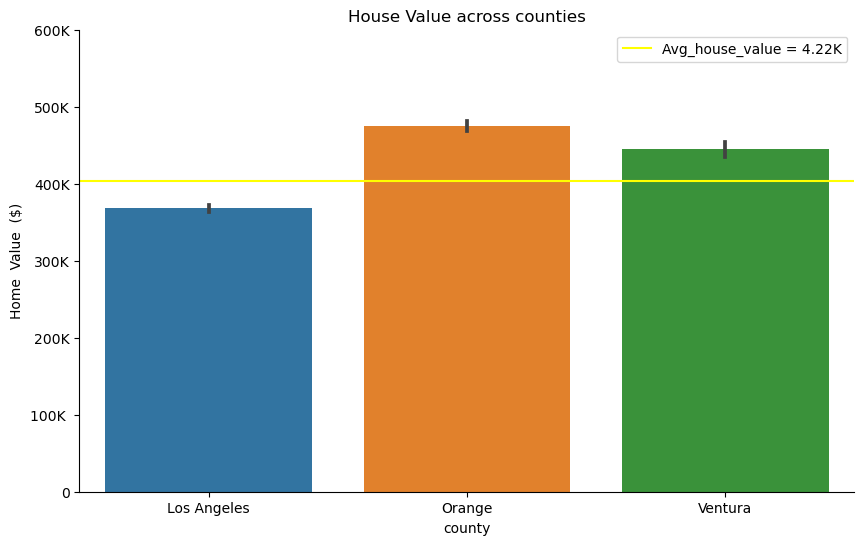

In [4]:
# get a graph from using function form explore module
explore.get_barplot_county(train)

From grpah, we can say that location has effect on home values. Los Angeles county houses are cheaper than houses in Orange county and Ventura county

### What is bathroom and bedroom role on home value?

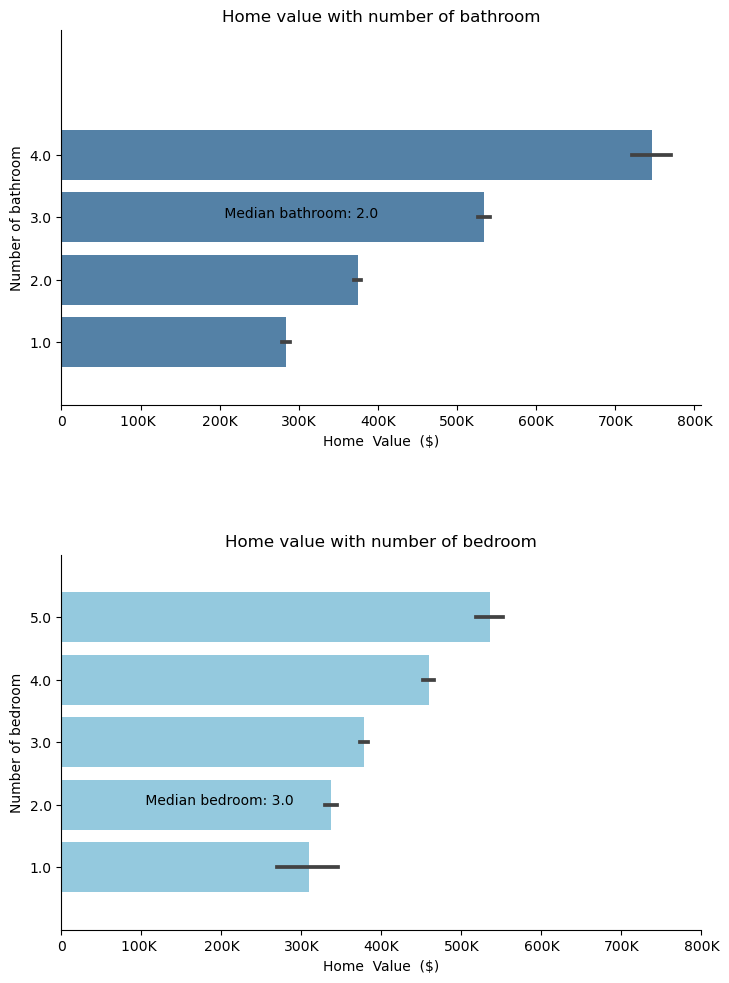

In [5]:
# get a graph from using function form explore module
explore.get_barplot_bathroom_bedroom(train)

From Graph, we can that home value increases with increases of number of bathroom and bedroom. Also, we can see that median number of bedroom is 3 and median number of bathroom is 2.

### Does a home with one bathroom is more expesnive than a home with two bedrooms?

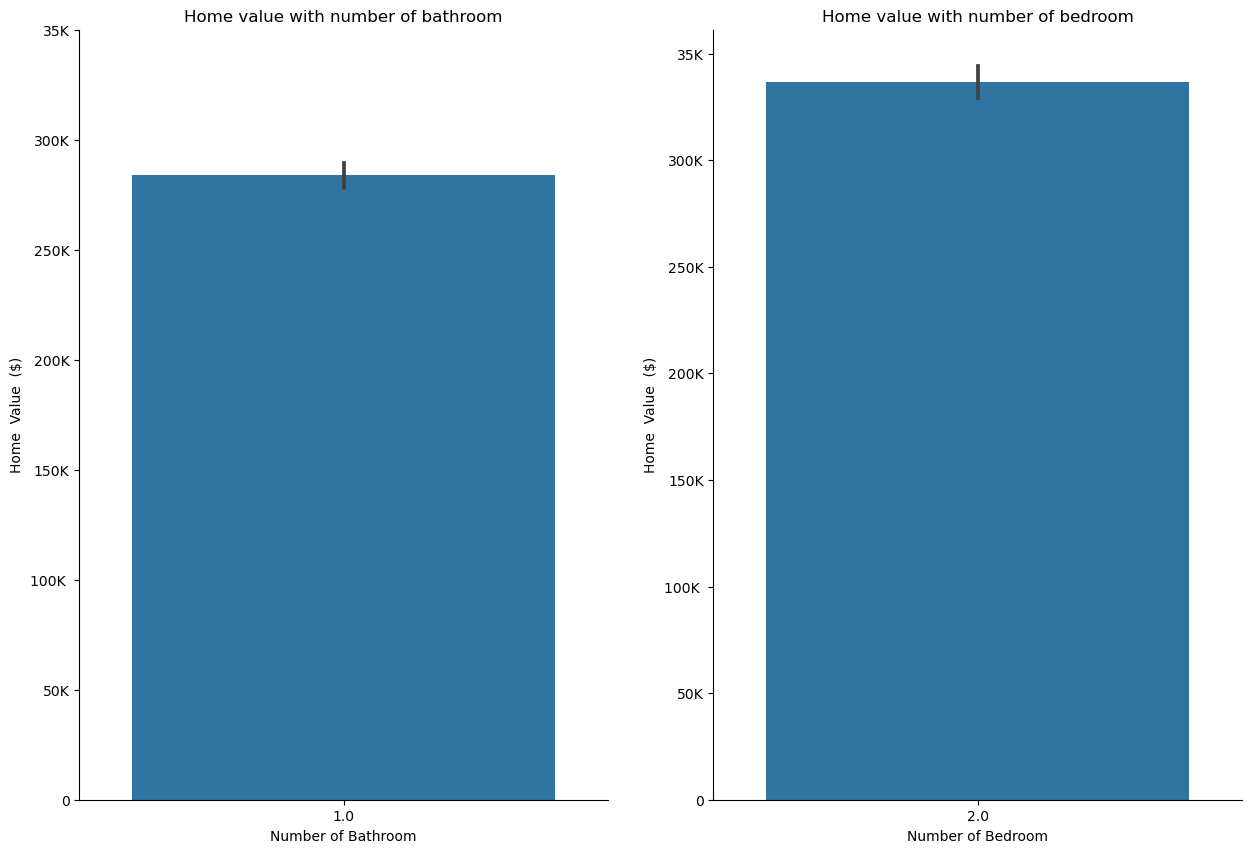

In [6]:
# get a graph from using function form explore module
explore.get_barplot_one_bathroom_two_bedroom(train)

From graph it looks like that a home with one bathroom is cheaper than a home with 2 bedroom. I will perfrom independent t- test(1 tail, a significantly larger) to see if a home with one bathroom is cheaper than a home with 2 bedroom.

In [7]:
# get result from independetn t-test using function from explore module
explore.ind_t_test_one_bathroom_two_bedroom(train)

Null Hypothesis: Home with one bathroom has less than or equal value to home with two bedroom

Alternative Hypothesis: Home with one bathroom has greater value than home with two bedroom

alpha: 0.05
t: -10.913710255250956
p: 1.523217710301919e-27

We fail to reject null hypothesis

It appears that Home with one bathroom has less than or equal value to home with two bedroom
--------------------------------------------------------------------------------------------



From inependent t-test, we founs that P-value is less tha alpha value and t- value greater than 0 so, we fail to reject Null Hypothesis. The result support our conclusion from the graph,  and we can say that a home with one bathroom is cheaper or equal to home with two bedrooms

### What is relation of area to home value?

<Figure size 1000x600 with 0 Axes>

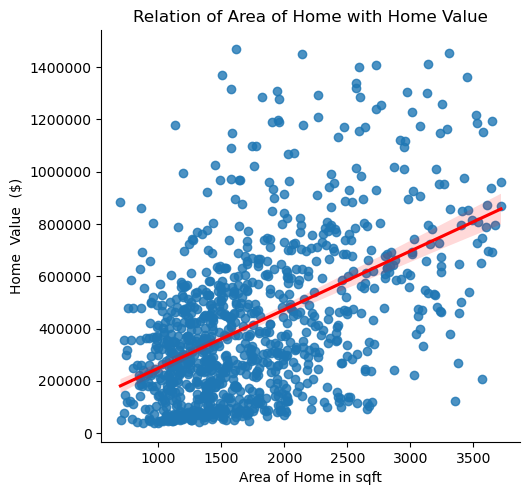

In [8]:
# get a graph from using function form explore module
explore.get_lmplot(train)

From graph, we can say that there exists a positive relation between area of home in sqft and home value. I will perform corelation test: pearsonr test to see if the conclusion from the graph is accurate.

In [9]:
# get result from pearsonr test using function from explore module

explore.corelation_sqft_tax_amount( train)

Null Hypothesis: There is no linear colrealtion between area and home value

Alternative Hypothesis: There is linear colrealtion between area and home value

r = 0.470969512846164
p     = 0.0

We reject null hypothesis
There is linear colrealtion between area and home value
--------------------------------------------------------------------------------------------



From Pearsonr corelation test's result, we found that P value is 0, r value is significant, and reject the Null Hypothesis. From graph and pearsonr test, we can say that theres is linear corelation between between area of home and the home value.

####  Corelation Heat Map

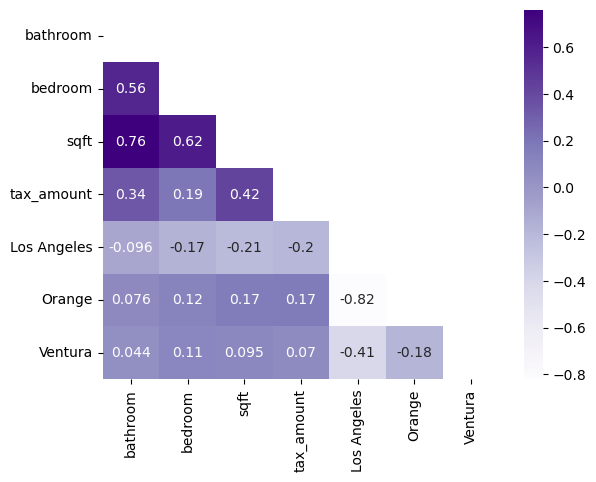

In [10]:
# get heat map using function from explore module

explore.get_corelation_map(train)

We can see that bathroom and sqft have higher corelation with tax_amount, our target. 

### Exploration Summary:
- bathroom, bedroom, sqft, location are driving attributes of home value.
- Higher number of bathroom and bedroom means higher home value.
- Increase in area leads in increase of home value.
- Los Angeles county has the home with less value that ventura and orange county
- bathroom and sqft have high corelation with our targer so  i will only use those for modelling.

## Modeling
-  I will use train data and validate data on different models to get the model that performs the best.Then, I will use the test data on the best model to get predicitons.
- I will use my baseline RMSE as my evaluation metric.
- I will use following four modelsto get the best model:
    - Model 1: Linear Regression(OLS)
    - Model 2: LASSOLARS
    - Model 3: TweedieRegressor
    - Model 4: Polynomial Regression

#### Scale data: 

 I will use MinMaxScaler to scale our data to normalize range of attributes. 

In [11]:
# scale data using function from modelling module
train_scaled, validate_scaled, test_scaled= modelling.scale_data(train, validate, test, 
                                                       columns_to_scale=['bathroom', 'sqft'],
                                                       return_scaler=False)

In [12]:
# create features using function from modelling module

X_train, y_train, X_validate, y_validate, X_test, y_test = modelling.X_y_split(train_scaled, validate_scaled, test_scaled, 'tax_amount')


### Baseline RMSE

In [13]:
# get RMSE on train and validate data using mean from function of modelling module
modelling.print_rmse_baseline(train,validate,'tax_amount')

RMSE using mean: 
train_RMSE: 282783.9723515096
validate RMSE: 276920.1915397434


### Comparing RMSE of Models

In [14]:
# get datafraem to comapre RMSE of models using function from modelling module
rmse_df= modelling.rmse_models(X_train,y_train,X_validate,y_validate,train, validate, 'tax_amount')
rmse_df

,train_RMSE,validate_RMSE
baseline,282783.972352,276920.19154
LinearRegreesion,245857.320000,241314.12000
LassoLars(alpha=1),245849.760000,241300.07000
"TweedieRegreesor(power=1, alpha=0)",245395.210000,240971.32000
Polynomial Regression(degree=3),244149.930000,239711.79000


<Figure size 800x1000 with 0 Axes>

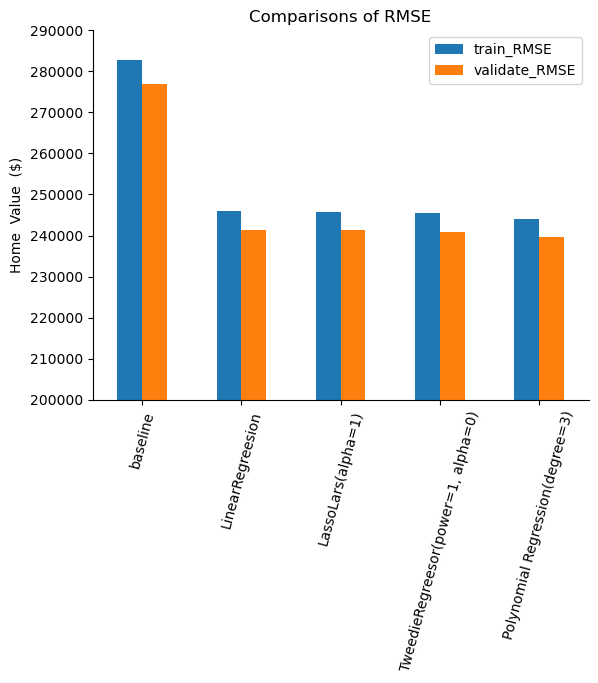

In [15]:
# get visualization to comapre RMSE of models using function from modelling module
modelling.plot_rmse(rmse_df)

Polynomial Regression with degree of 3 performed best with RMSE of 246241.41 for train data and RMSE of 241633.930 for validate data. It has the lowest RMSE for both train data and validate data. It's RMSE on train beats the baseline RMSE on train by about 13.6 %.

### Model Evaluation

In [16]:
# get RMSE on test using polynomial model with degree of 3 using function from modelling module
rmse_test = modelling.polynomial_test(X_train,y_train,X_test,y_test, 'tax_amount', 3)

Using polynomial Regresion on test
RMSE : 243241.06
r2 : 0.2543892614088439



Polynomial Regression with degree of 3 to has RMSE of 243241.06 for test data, which is better than baseline RMSE and train RMSE. It beats baseline RMSE on train by about 13.98%

### Modelling summary
- All models perfomed better than baseline on train and validat data.
- All models perfomed better on validate to train
- Polynomial Regression with degree of 3 performed best with RMSE of 246241.41 for train data and RMSE of 241633.930 for validate data. 
- Polynomial Regression with degree of 3 to has RMSE of 243241.06 for test data, which is better than baseline RMSE and train RMSE

## Conclusions 

- bathroom, bedroom, sqft, location are driving attributes of home value.
- Higher number of bathroom and bedroom means higher home value.
- Increase in area leads in increase of home value.
- Los Angeles county has the home with less value that ventura and orange county
- bathroom and sqft have high corelation with our target.
- Polynomial Regression with degree of 3 to has RMSE which is better than baseline RMSE and train RMSE


### Recommendations
 - explore other attributes to see thier effects on target variables

### Next Steps
- explore other attributes to see thier effects on target variables.
- use differnt model  to improve predictions.